# Stock Prices Paths Simulation

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import display
from yahoo_fin import options
from yahoo_fin import stock_info as si

import BlackScholes as bs
import Merton as m
import Kou as k
import VarianceGamma as vg

np.random.seed(27)

### Get Option Data

In [2]:
symbol = 'META'  # AAPL, TSLA, MSFT, META, CAT, STM, GOOG, NFLX, AMZN
dates = options.get_expiration_dates(symbol)
print(dates)

T_str = 'June 21, 2024'  # This is the first "greater than a year" expiry date
calls = options.get_calls(symbol, T_str)
puts = options.get_puts(symbol, T_str)

T_datetime = datetime.strptime(T_str, '%B %d, %Y')
ttm = (T_datetime - datetime.now()).days / 365.0  # to use the time to maturity in float mode

calls['Time-to-maturity'] = ttm
puts['Time-to-maturity'] = ttm
display(calls.columns)

print(calls.head())

['June 23, 2023', 'June 30, 2023', 'July 7, 2023', 'July 14, 2023', 'July 21, 2023', 'July 28, 2023', 'August 18, 2023', 'September 15, 2023', 'October 20, 2023', 'November 17, 2023', 'December 15, 2023', 'January 19, 2024', 'February 16, 2024', 'March 15, 2024', 'June 21, 2024', 'September 20, 2024', 'January 17, 2025', 'June 20, 2025', 'December 19, 2025']


Index(['Contract Name', 'Last Trade Date', 'Strike', 'Last Price', 'Bid',
       'Ask', 'Change', '% Change', 'Volume', 'Open Interest',
       'Implied Volatility', 'Time-to-maturity'],
      dtype='object')

         Contract Name         Last Trade Date  Strike  Last Price     Bid   
0  META240621C00005000   2023-06-14 1:23PM EDT     5.0      266.70  272.05  \
1  META240621C00010000   2023-02-27 3:36PM EDT    10.0      160.70  194.00   
2  META240621C00015000   2023-06-15 9:30AM EDT    15.0      258.27  262.30   
3  META240621C00020000  2023-02-28 11:10AM EDT    20.0      157.30  187.85   
4  META240621C00025000   2023-06-15 9:30AM EDT    25.0      248.78  252.85   

      Ask  Change % Change Volume  Open Interest Implied Volatility   
0  275.95     0.0        -      1            237            280.18%  \
1  197.90     0.0        -      4             11              0.00%   
2  266.20     0.0        -      2             27            114.06%   
3  189.75     0.0        -      2             26              0.00%   
4  256.75     0.0        -      2             96            117.97%   

   Time-to-maturity  
0               1.0  
1               1.0  
2               1.0  
3               

#### Find historic volatility

In [3]:
# historic volatility
stock_data = si.get_data(symbol, start_date='31/05/2021', end_date='31/05/2023')
print(stock_data.head())
stock_data['Returns'] = stock_data['close'] / stock_data['close'].shift()
stock_data['Log Returns'] = np.log(stock_data['Returns'])
print(stock_data.head())
volatility = stock_data['Log Returns'].std() * np.sqrt(252)
print(f'Historical volatility: {round(volatility, 3)}')

                  open        high         low       close    adjclose   
2021-06-01  330.149994  331.420013  326.640015  329.130005  329.130005  \
2021-06-02  330.380005  331.869995  327.119995  329.149994  329.149994   
2021-06-03  325.779999  327.380005  323.480011  326.040009  326.040009   
2021-06-04  325.899994  332.459991  325.179993  330.350006  330.350006   
2021-06-07  329.480011  337.690002  328.929993  336.579987  336.579987   

              volume ticker  
2021-06-01  11765900   META  
2021-06-02  11654300   META  
2021-06-03  12610800   META  
2021-06-04  13289400   META  
2021-06-07  20136700   META  
                  open        high         low       close    adjclose   
2021-06-01  330.149994  331.420013  326.640015  329.130005  329.130005  \
2021-06-02  330.380005  331.869995  327.119995  329.149994  329.149994   
2021-06-03  325.779999  327.380005  323.480011  326.040009  326.040009   
2021-06-04  325.899994  332.459991  325.179993  330.350006  330.350006   
2021-

### Data preparation

In [4]:
# convert the 'Implied Volatility' column to a numeric type
calls['Implied Volatility'] = pd.to_numeric(calls['Implied Volatility'].str.strip('%')) / 100
puts['Implied Volatility'] = pd.to_numeric(puts['Implied Volatility'].str.strip('%')) / 100
# choose one option as starting point
option = calls.iloc[np.random.randint(len(calls))]
print(option)

Contract Name            META240621C00100000
Last Trade Date       2023-06-13 11:30AM EDT
Strike                                 100.0
Last Price                            179.86
Bid                                    183.0
Ask                                    186.9
Change                                   0.0
% Change                                   -
Volume                                     1
Open Interest                           5184
Implied Volatility                    0.7916
Time-to-maturity                         1.0
Name: 19, dtype: object


#### Fix simulation parameters

In [5]:
# FIXED PARAMETERS (used for all models)
S0 = si.get_live_price(symbol)  # get live price of stock
print(f'{symbol} Current stock price: {round(S0, 2)}')
T = ttm  # Expiry Date in years
days = 252
paths = 1000
K = option[2]  # Strike price
sigma = volatility
r = 0.05  # risk.free interest rate
size = (days, paths)

META Current stock price: 279.14


### Black and Scholes model

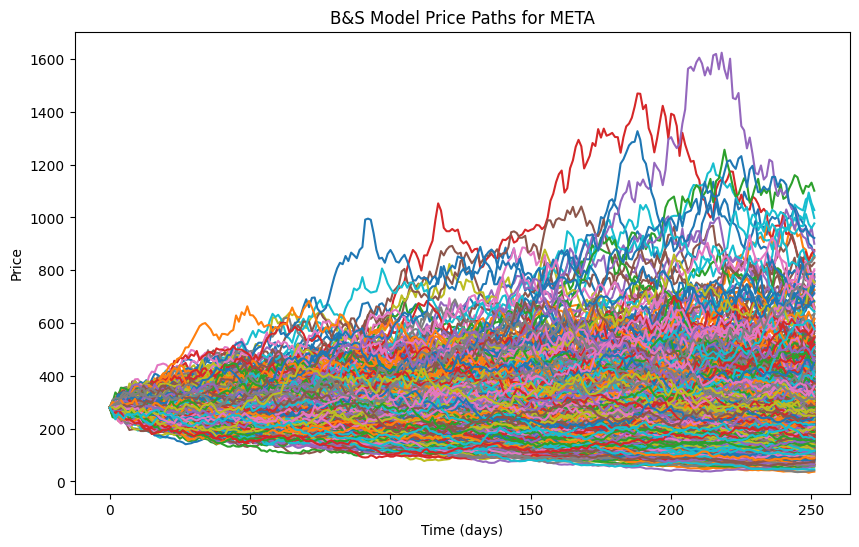

In [6]:
SBlackScholes = bs.BlackScholesPath(T, days, paths, sigma, r, S0)

bs.plotBSPath(SBlackScholes, symbol)  # Plot all paths

#### Plot a subset of 5 paths

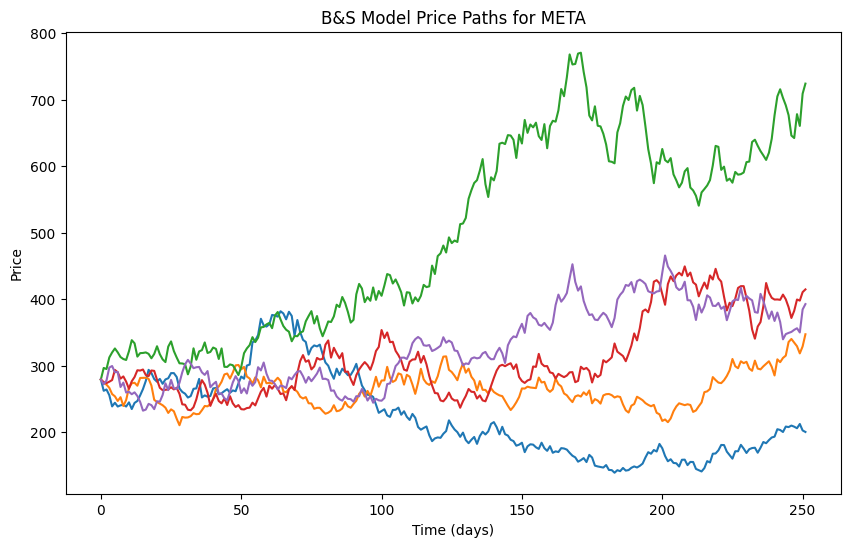

In [7]:
subset = 5  # Plot a subset of 5
SBS_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SBS_subset[path] = SBlackScholes[:, random_indices[path]]
bs.plotBSPath(SBS_subset.T, symbol)

#### Plot only one random path

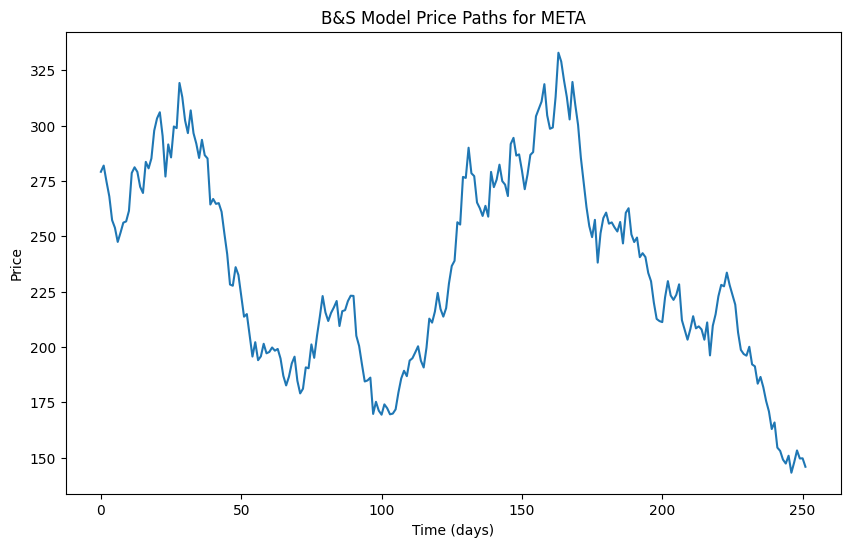

In [8]:
bs.plotBSPath(SBlackScholes[:, np.random.choice(paths)], symbol)  # Plot only one

### Merton Jump Diffusion model

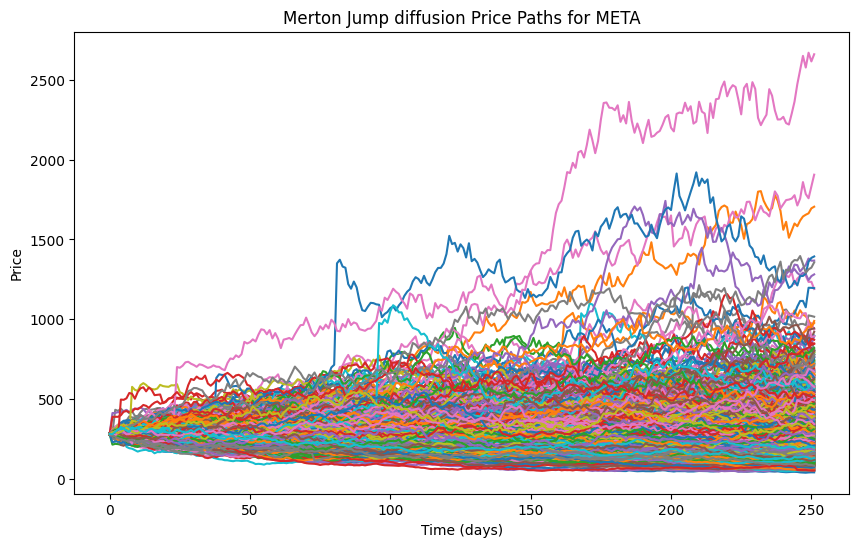

In [9]:
lamda = 0.5
jump_mean = 0
jump_std = 0.2
SMerton = m.MertonPath(T, days, paths, sigma, r, lamda, jump_mean, jump_std, S0)

m.plotMertonPath(SMerton, symbol)  # Plot all paths

#### Plot a subset of 5 paths

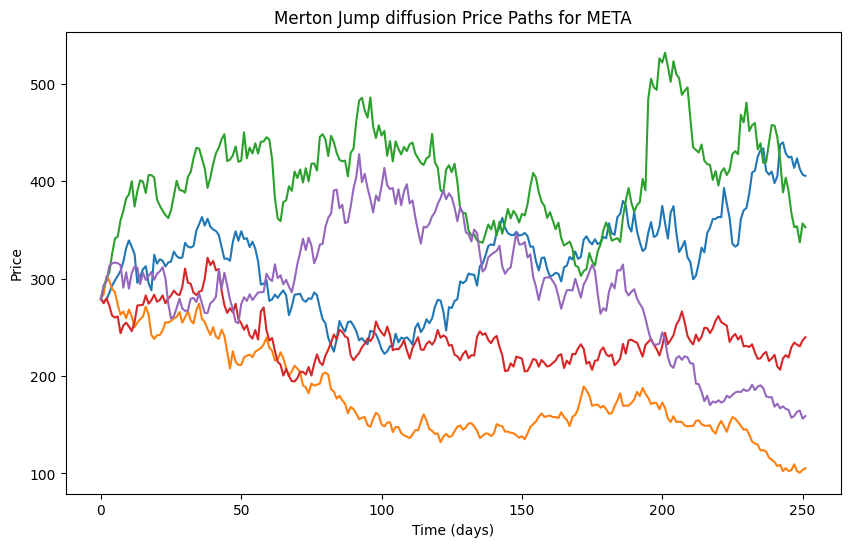

In [10]:
subset = 5  # Plot a subset of 5
SM_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SM_subset[path] = SMerton[:, random_indices[path]]
m.plotMertonPath(SM_subset.T, symbol)


#### Plot only one random path

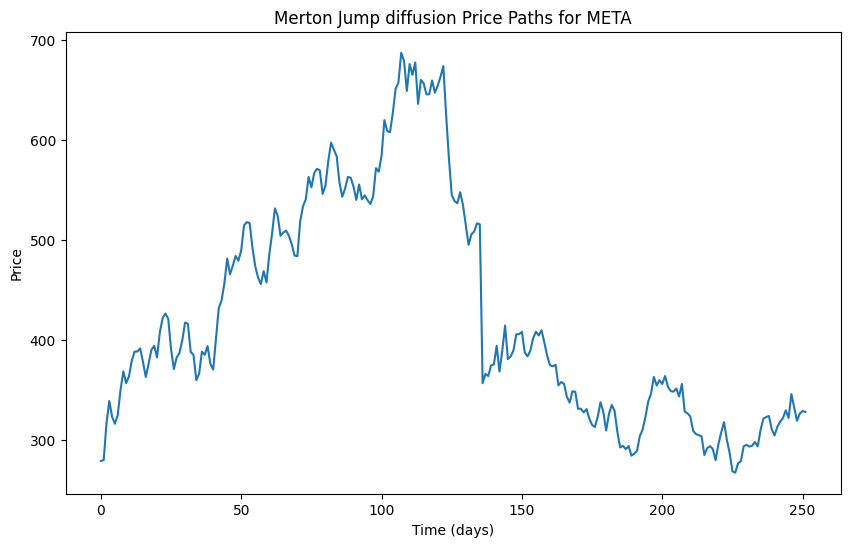

In [11]:
m.plotMertonPath(SMerton[:, np.random.choice(paths)], symbol)  # Plot only one

### Kou Jump Diffusion Model

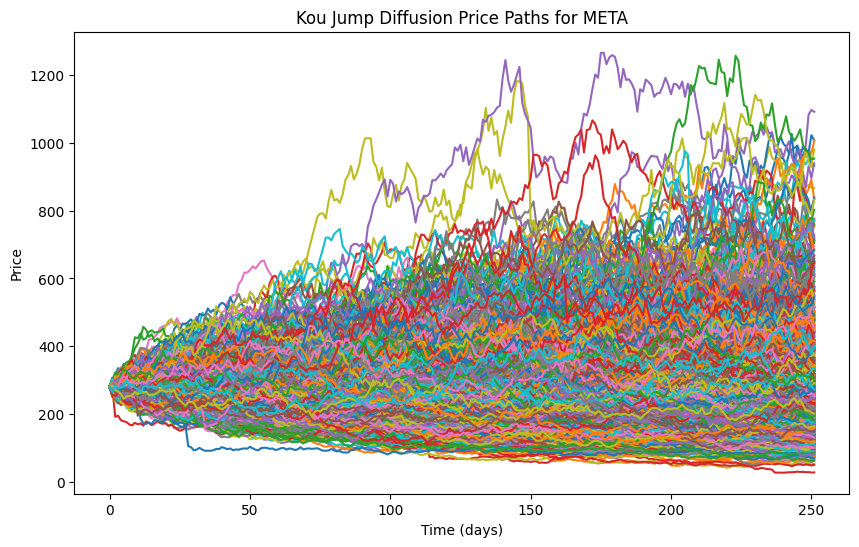

In [12]:
eta_1 = 10  # upward jump magnitude
eta_2 = 2  # downward jump
p = 0.4  # q = 0.6
SKou = k.KouPath(T, days, paths, sigma, r, lamda, p, eta_1, eta_2, S0)

# Plot all paths
k.plotKouPath(SKou, symbol)

#### Plot a subset of 5 paths

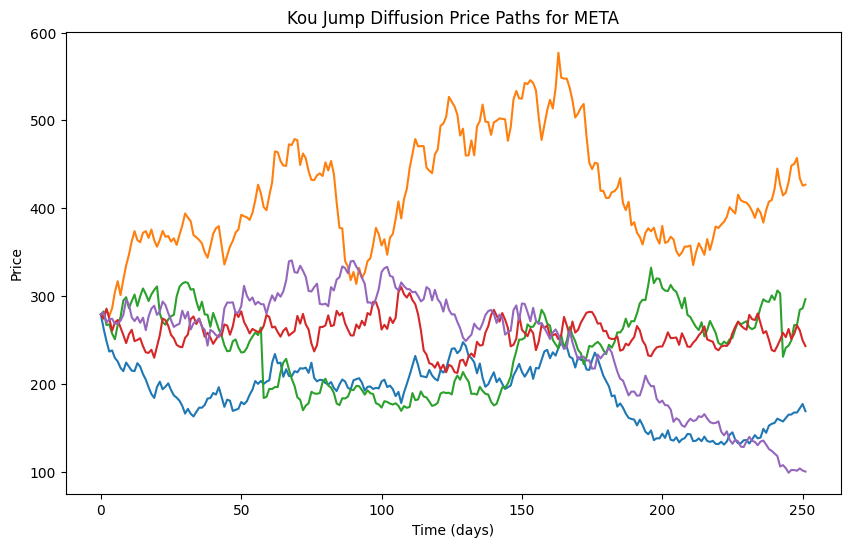

In [13]:
# Plot a subset of 5
subset = 5
SK_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SK_subset[path] = SKou[:, random_indices[path]]
k.plotKouPath(SK_subset.T, symbol)

#### Plot only one random path

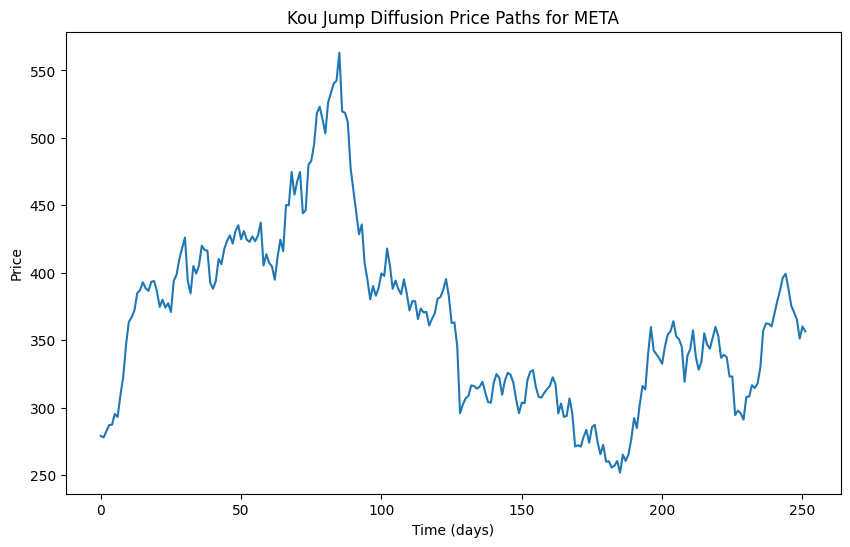

In [14]:
# Plot only one
k.plotKouPath(SKou[:, np.random.choice(paths)], symbol)

### Variance Gamma Model

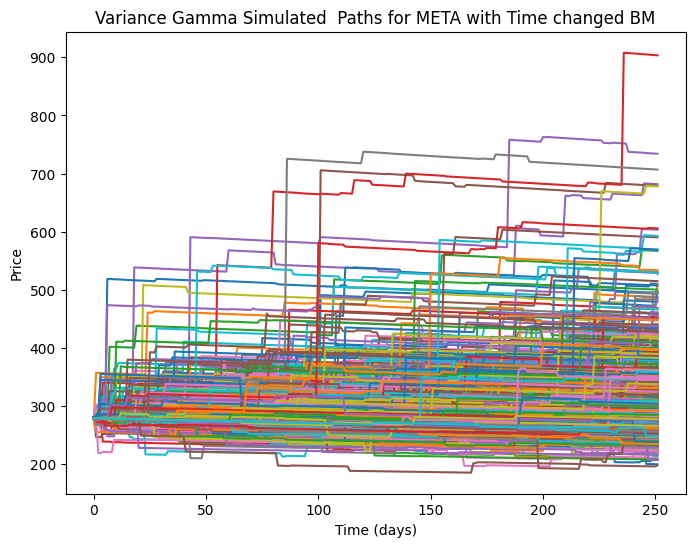

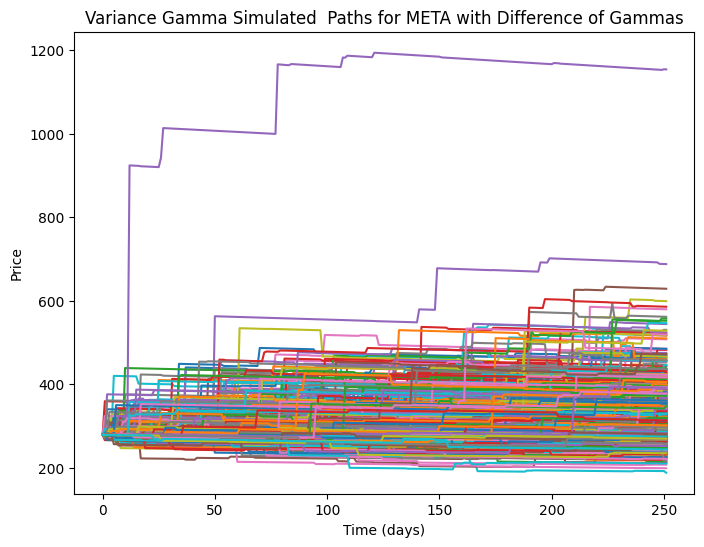

In [15]:
theta = 0.15
nu = 0.7
SVarGamma = vg.VarianceGammaPath1(T, days, paths, 0.15, 0.1, nu, theta, S0)
SVarGamma2 = vg.VarianceGammaPath2(T, days, paths, 0.15, 0.1, nu, theta, S0)

method = ['Time changed BM', 'Difference of Gammas']

# Plot all paths
vg.plotVGPath(SVarGamma, symbol, method[0])
vg.plotVGPath(SVarGamma2, symbol, method[1])

#### Plot a subset of 5 paths

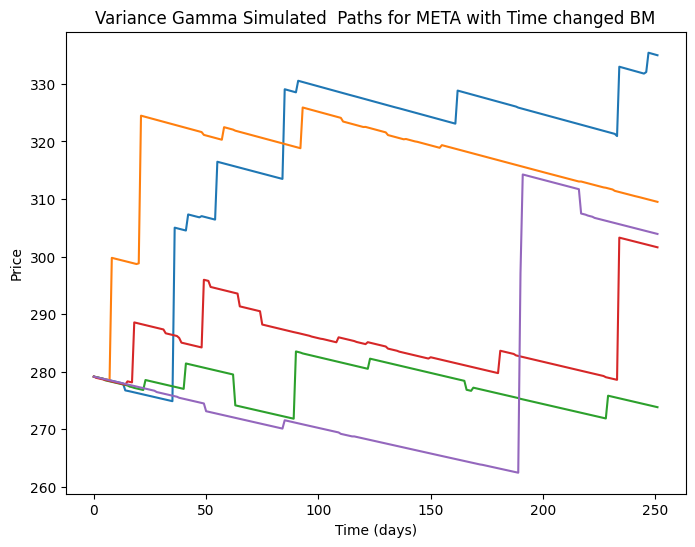

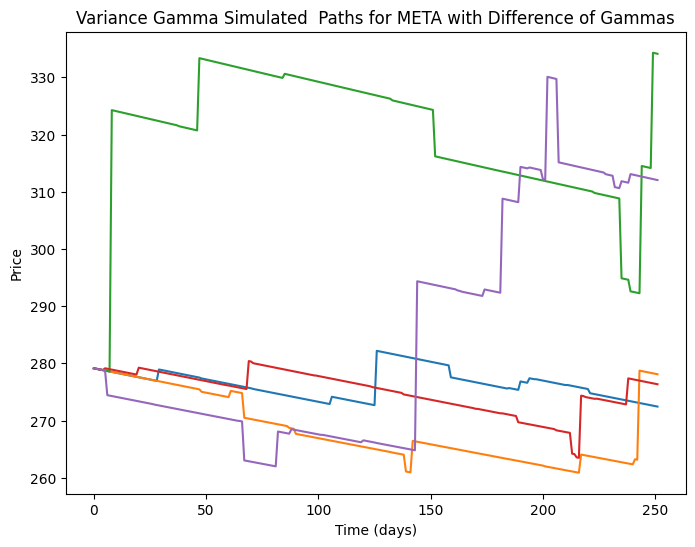

In [16]:
subset = 5  # Plot a subset of 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma[:, random_indices[path]]
vg.plotVGPath(SVG_subset.T, symbol, method[0])

subset = 5
SVG_subset = np.empty((subset, days))
random_indices = np.random.choice(paths, size=subset)
for path in range(subset):
    SVG_subset[path] = SVarGamma2[:, random_indices[path]]
vg.plotVGPath(SVG_subset.T, symbol, method[1])

#### Plot only one random path

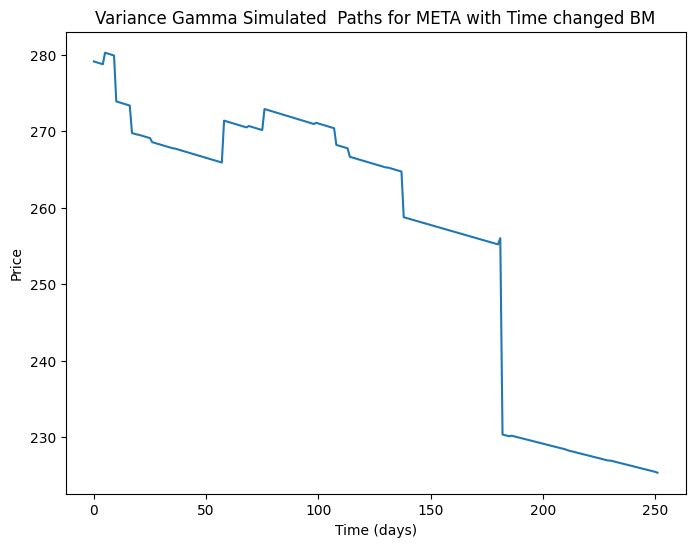

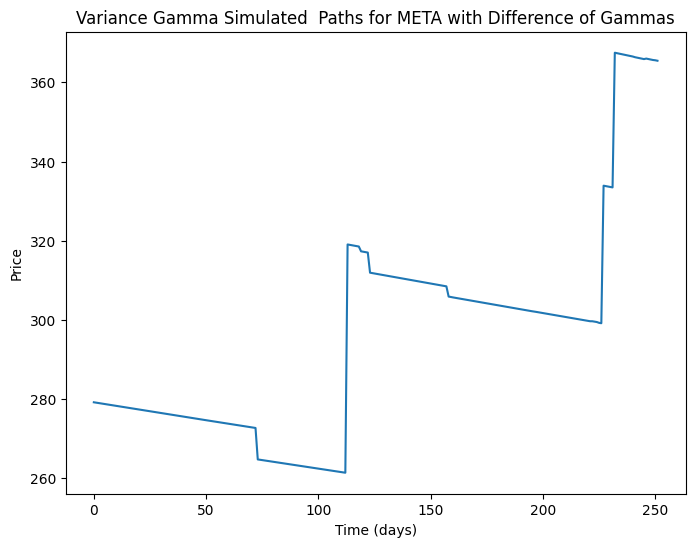

In [17]:
# Plot only one
vg.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[0])
vg.plotVGPath(SVarGamma[:, np.random.choice(paths)], symbol, method[1])

#### From Seneta 2004, moments method

In [18]:
# Estimate params of VG (ref. Seneta 2004)
sigma_est = np.sqrt(vg.find_moment(2, theta, nu, sigma))
theta_est = sigma*(vg.find_moment(3,theta, nu, sigma))/(3*nu)
nu_est = (vg.find_moment(4, theta, nu, sigma)/3) - 1

print(f'Variance Gamma Estimated Params\n\t\tSTART\tEXT')
print(f'Sigma:  {round(sigma,2)} -> {round(sigma_est,4)}')
print(f'Theta: {theta} -> {round(theta_est,4)}')
print(f'Nu:     {nu} -> {round(nu_est,4)}')

Variance Gamma Estimated Params
		START	EXT
Sigma:  0.55 -> 0.1402
Theta: 0.15 -> 0.0011
Nu:     0.7 -> -1.0


### Visulaize distributions

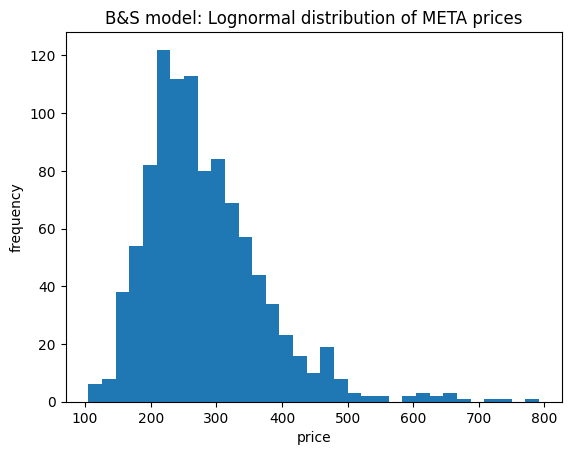

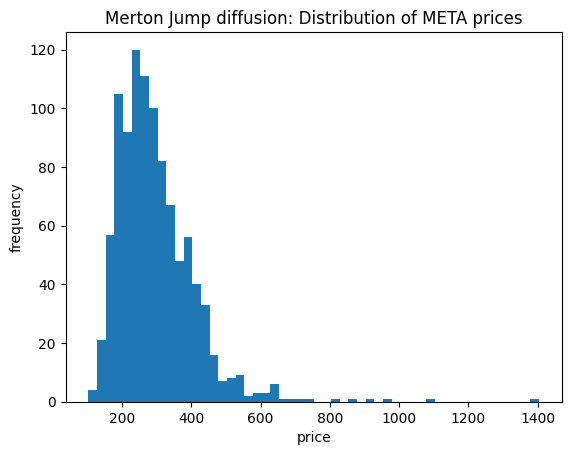

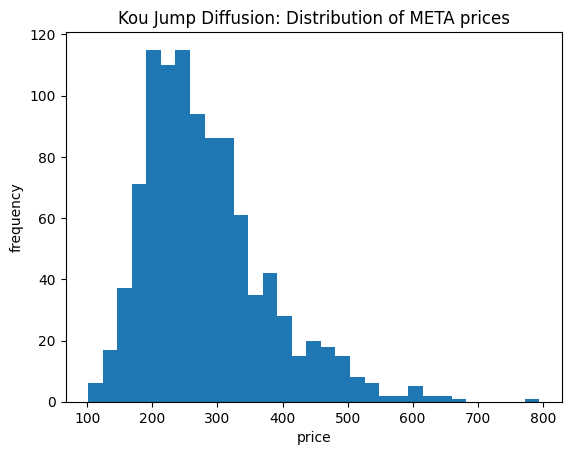

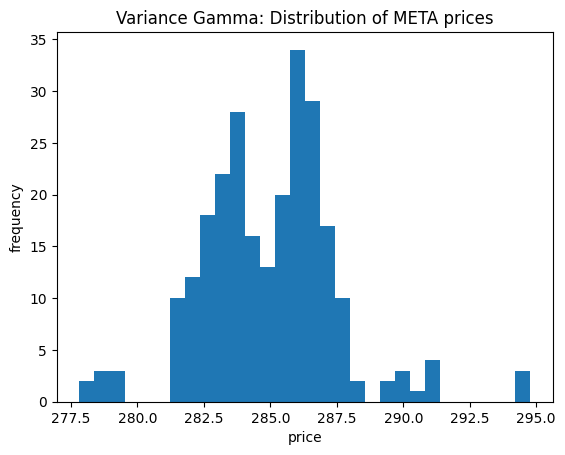

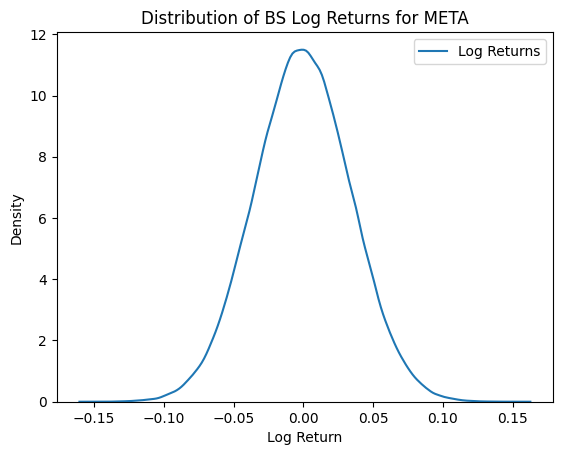

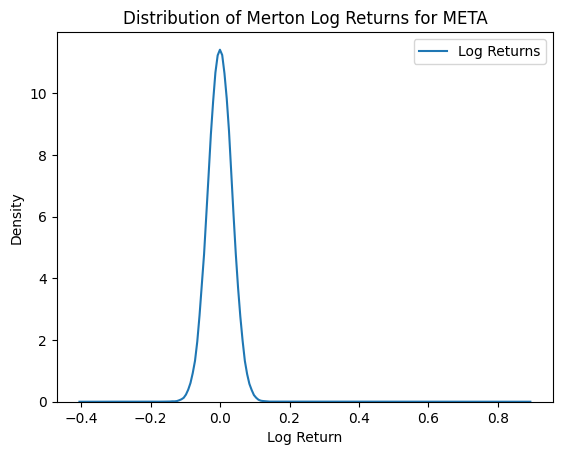

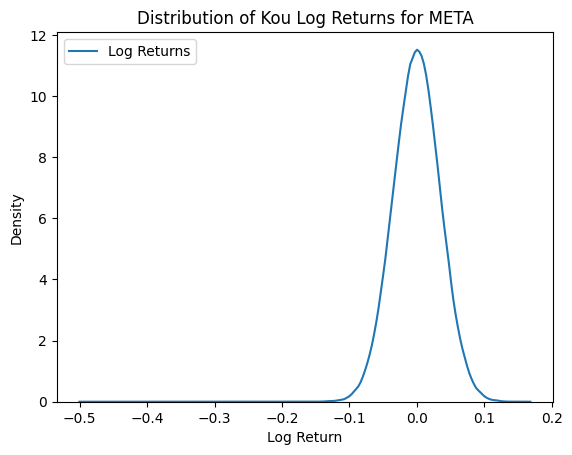

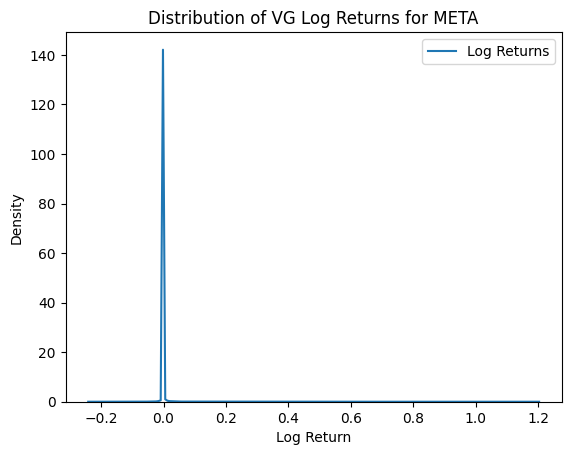

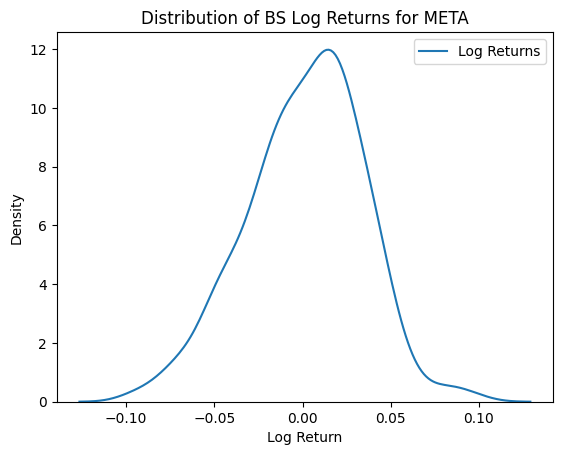

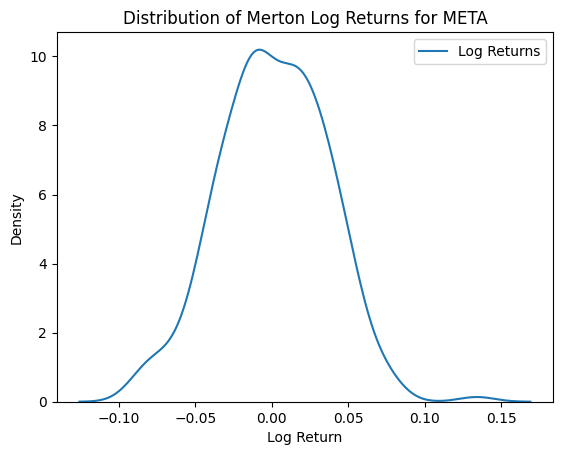

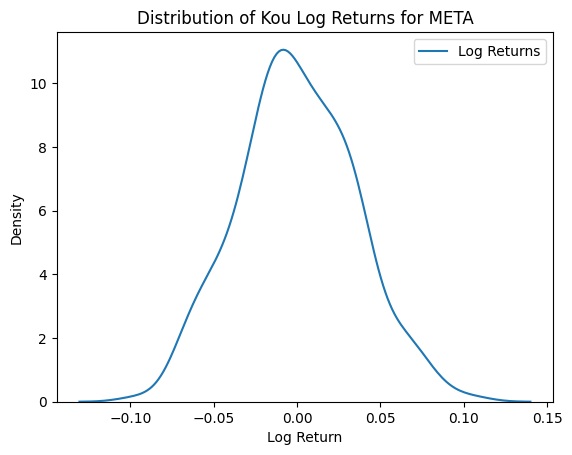

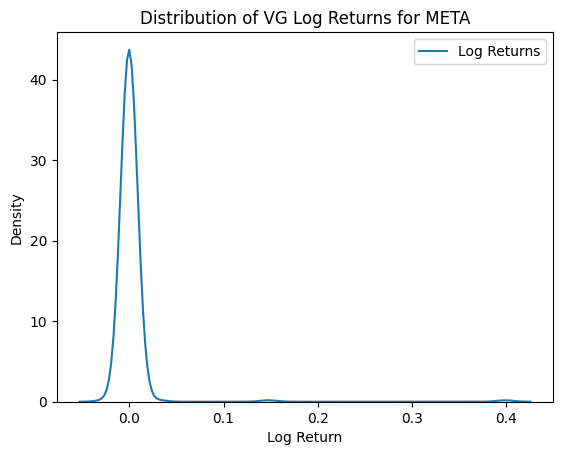

In [19]:
# %%%%%%%%%%%%%%%%%%%%%%%%    Visualize distributions  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# Average prices
bs.plotBSDist(SBlackScholes, symbol)
m.plotMertonDist(SMerton, symbol)
k.plotKouDist(SKou, symbol)
vg.plotVGDist(SVG_subset, symbol)

# Log returns ALL PATHS
bs.plotBSLogReturns(SBlackScholes, symbol)
m.plotMertonLogReturns(SMerton, symbol)
k.plotKouLogReturns(SKou, symbol)
vg.plotVGLogReturns(SVarGamma2, symbol)

# Log returns ONE RANDOM
bs.plotBSLogReturns(SBlackScholes[:, np.random.choice(paths)], symbol)
m.plotMertonLogReturns(SMerton[:, np.random.choice(paths)], symbol)
k.plotKouLogReturns(SKou[:, np.random.choice(paths)], symbol)
vg.plotVGLogReturns(SVarGamma2[:, np.random.choice(paths)], symbol)